# Analysis of SARS-Cov-2 intrasample variation

You can access your data via the dataset number. For example, ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/galaxy-ipython).

In [1]:
# Set display to the full length

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /opt/conda/lib/python3.5/site-packages (20.0.2)


In [ ]:
!pip install --upgrade seaborn

In [ ]:
# install pandasql
!pip install pandasql

In [5]:
import pandas as pd
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
%matplotlib inline

This notebook imports two datasets from Galaxy history:

 - a table of variants detected by mapping SRR10903401, SRR10903402, and SRR10971381 to 2019-nCoV reference NC_045512 (variable `var`)
 - a GenBank file for NC_045512

In [6]:
# Import two datasets
# The number inside `get()` function corresponds to history ID

var_file = 39     # Number of history item with variant list
ncov_gb = 8       # Number of histoiry item containing genbank annoration for NC_045512

get(var_file)
get(ncov_gb)

'/import/8'

In [7]:
# Clean artifacts of SNPeff from file headers

!cat {var_file} | sed s/EFF\\\[\\\*\\\]\.//g > var.tab

In [8]:
# Create dataframes

var  = pd.read_csv('var.tab', sep='\t')

In [9]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON
0,SRR10903401,NC_045512,1409,C,T,124,0.040323,1,"66,53,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat
1,SRR10903401,NC_045512,1821,G,A,95,0.094737,0,"49,37,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt
2,SRR10903401,NC_045512,1895,G,A,107,0.037383,0,"51,52,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata
3,SRR10903401,NC_045512,2407,G,T,122,0.024590,0,"57,62,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG


In [10]:
# Add fiels describing viant type and set it to "I" (indels) for those rows that reference or alternative are gaps (-)
# or are of unequial length

var.loc[ ( var['REF'] == '-' ) | ( var['ALT'] == '-' ) ,'type'] = 'I'
var.loc[ ( var['ALT'].str.len() != var['REF'].str.len() ), 'type' ] = 'I'

In [11]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR10903401,NC_045512,1409,C,T,124,0.040323,1,"66,53,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat,NaN
1,SRR10903401,NC_045512,1821,G,A,95,0.094737,0,"49,37,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt,NaN
2,SRR10903401,NC_045512,1895,G,A,107,0.037383,0,"51,52,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata,NaN
3,SRR10903401,NC_045512,2407,G,T,122,0.024590,0,"57,62,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT,NaN
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG,NaN


In [12]:
# Set type field for SNPs
var.loc[ ( var['REF'].str.len() == 1 ) & ( var['ALT'].str.len() == 1 ) & (var['type'].isnull()), 'type'] = 'S'

In [13]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR10903401,NC_045512,1409,C,T,124,0.040323,1,"66,53,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat,S
1,SRR10903401,NC_045512,1821,G,A,95,0.094737,0,"49,37,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt,S
2,SRR10903401,NC_045512,1895,G,A,107,0.037383,0,"51,52,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata,S
3,SRR10903401,NC_045512,2407,G,T,122,0.024590,0,"57,62,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT,S
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG,S


In [14]:
# Set type field for MNPs 
var.loc[ ( ( var['REF'].str.len() > 1 ) & ( var['ALT'].str.len() == var['REF'].str.len() ) ) , 'type'  ] = 'M'

In [15]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR10903401,NC_045512,1409,C,T,124,0.040323,1,"66,53,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat,S
1,SRR10903401,NC_045512,1821,G,A,95,0.094737,0,"49,37,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt,S
2,SRR10903401,NC_045512,1895,G,A,107,0.037383,0,"51,52,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata,S
3,SRR10903401,NC_045512,2407,G,T,122,0.024590,0,"57,62,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT,S
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG,S


In [16]:
# Select counts by Sample and by type

pysqldf('select Sample, type, count(*) from var group by Sample, type')

,Sample,type,count(*)
0,SRR10903401,S,73
1,SRR10903402,S,222
2,SRR10971381,S,367


In [17]:
# Select counts by Sample and by type for SNPs wil allele frequency above 5%

pysqldf('select Sample, type, count(*) from var where AF >= 0.05 group by Sample, type')

,Sample,type,count(*)
0,SRR10903401,S,11
1,SRR10903402,S,5
2,SRR10971381,S,33


In [18]:
pysqldf('select Sample, EFFECT, count(*) as N from var group by Sample, EFFECT').pivot(index='Sample',columns='EFFECT',values='N').fillna(0)

EFFECT,.,NON_SYNONYMOUS_CODING,START_LOST,STOP_GAINED,STOP_LOST+SPLICE_SITE_REGION,SYNONYMOUS_CODING
Sample,,,,,,
SRR10903401,0.0,46.0,1.0,3.0,0.0,23.0
SRR10903402,4.0,144.0,0.0,4.0,0.0,70.0
SRR10971381,11.0,217.0,4.0,14.0,1.0,120.0


In [19]:
pysqldf('select Sample, EFFECT, count(*) as N from var where AF >= 0.05 group by Sample, EFFECT').pivot(index='Sample',columns='EFFECT',values='N').fillna(0)

EFFECT,.,NON_SYNONYMOUS_CODING,START_LOST,STOP_GAINED,STOP_LOST+SPLICE_SITE_REGION,SYNONYMOUS_CODING
Sample,,,,,,
SRR10903401,0.0,5.0,0.0,2.0,0.0,4.0
SRR10903402,1.0,3.0,0.0,0.0,0.0,1.0
SRR10971381,0.0,15.0,1.0,0.0,1.0,16.0


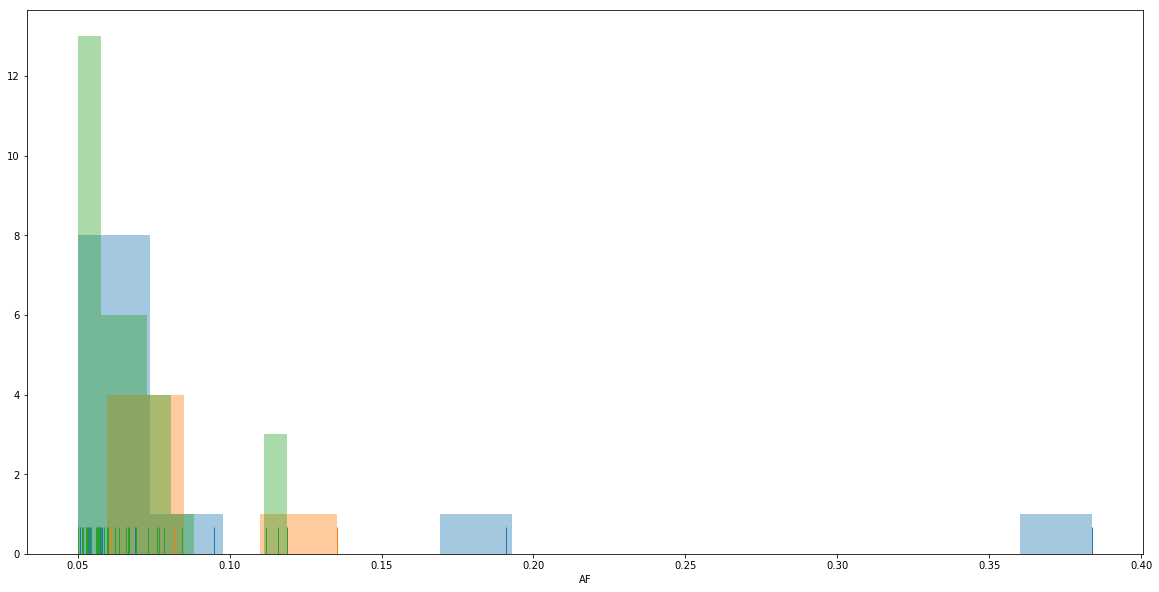

In [20]:
# Plot histogram of allele frequencies for three sample
# Restricted to variants with minor allele frequency above 5%

plt.figure(figsize=(20,10))
for sample in var['Sample'].unique():
    sns.distplot(var['AF'][(var['AF']>=0.05) & (var['Sample']==sample)],kde=False,rug=True)

In [21]:
# Define categorical columns

for col in ['IMPACT','FUNCLASS','EFFECT']:
    var[col] = var[col].astype('category')

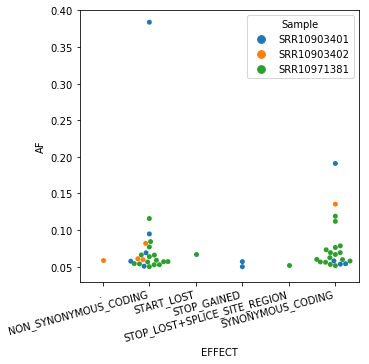

In [22]:
# Plot Allele frequences by samples and functional categories

plt.figure(figsize=(5,5))
g = sns.swarmplot(x='EFFECT',y='AF',data=var[var['AF']>=0.05], hue='Sample')
g.set_xticklabels(g.get_xticklabels(), rotation=15, horizontalalignment='right')

In [23]:
# Read GenBank file with annotations for NC_045512
from Bio import SeqIO
record = SeqIO.read('{}'.format(str(ncov_gb)),'genbank')

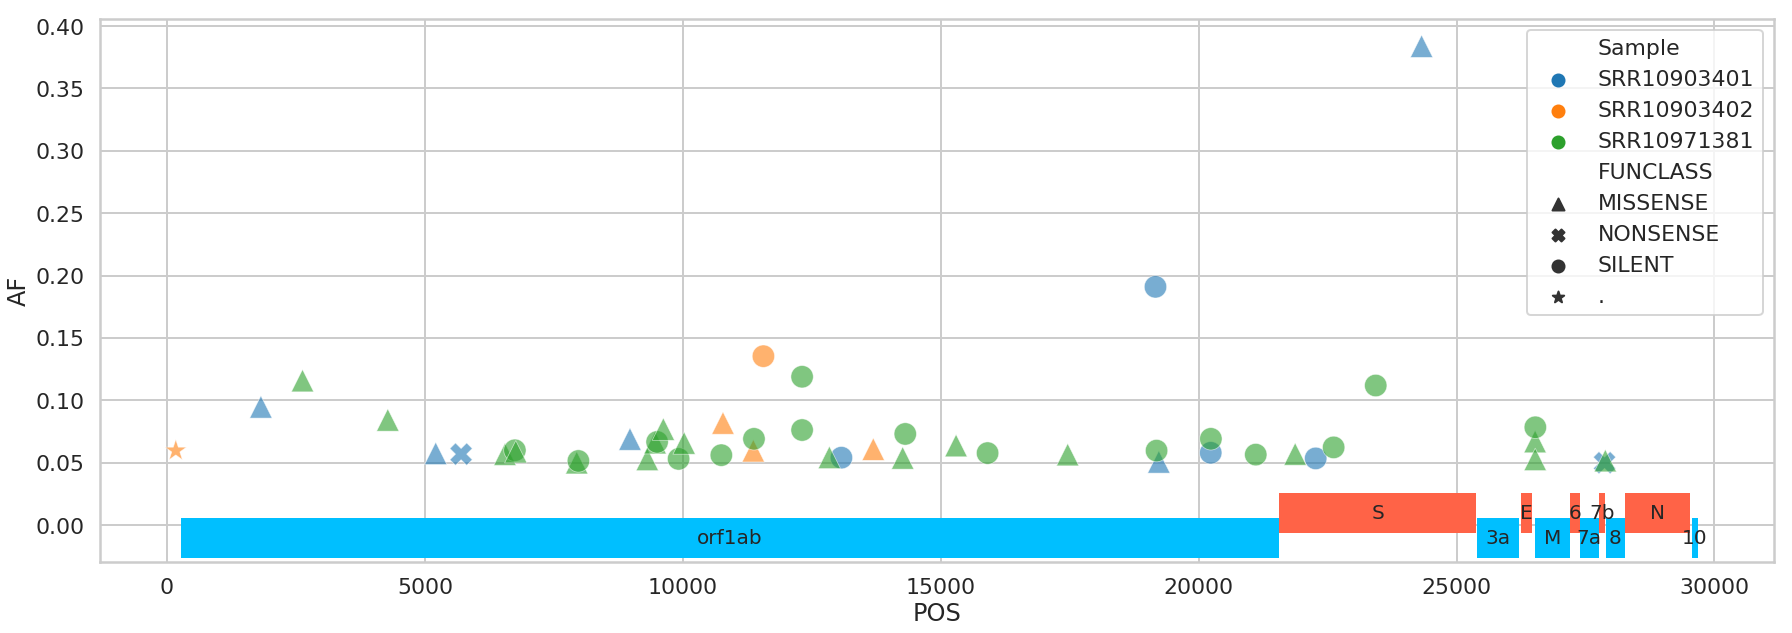

In [24]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
sns.set_context("poster")
sns.set_style("whitegrid")
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o"}
sns.scatterplot(x='POS',y='AF',data=var[var['AF']>=0.05],hue='Sample',style='FUNCLASS',legend='brief',alpha=0.6,s=500,markers=markers)
i = 0
for feature in record.features:
    if feature.type == 'gene':
        i += 1
        gene_name = feature.qualifiers['gene'][0]
        if gene_name.startswith('ORF'):
            gene_name=gene_name[3:]
        if i % 2 == 0:
            color ='tomato'
            y = 0.01
        else:
            color ='deepskyblue'
            y = -0.01
        plt.hlines(y,feature.location._start.position, feature.location._end.position, linewidth=40,color=color)
        plt.text(feature.location._start.position+(feature.location._end.position-feature.location._start.position)//2, y, gene_name,horizontalalignment='center',verticalalignment='center',fontsize=20)

In [25]:
# List varinats by Sample and by position highlighting allel frequencies

var[var['AF']>0.05].style.bar(subset=['AF'],color='#d65f5f')